In [ ]:
# Install the required libraries.
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

     - 2.5 MB 6.2 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.9 MB/s eta 0:00:00
  Created wheel for yt-dlp: filename=yt_dlp-2023.7.6-py2.py3-none-any.whl size=2800676 sha256=5d57d8c7f4ae9bec798a9c830d2af1c463ec9b049f70c393b226910b1ffca1d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-waufqa3s/wheels/4c/91/d1/c5369304e2f7afb660bb6eee093af5a7d3c0ea05a3c1e8c797
Successfully built yt-dlp
  Attempting uninstall: certifi
    Found existing installation: certifi 2023.7

In [ ]:
# Import the required libraries.
import os
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import yt_dlp as youtube_dl
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from moviepy.editor import VideoFileClip

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Downlaod the UCF50 Dataset.
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset.
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Display the names of all classes/categories in UCF50.
print(all_classes_names)

# Generate a list of 50 values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
# Iterating through all the generated random values.
for counter, selected_class_name in enumerate(all_classes_names, 1):

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(10, 5, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ['HorseRace', 'TaiChi', 'Swing', 'Punch', 'WalkingWithDog',
                'PushUps', 'MilitaryParade', 'GolfSwing', 'PlayingGuitar', 'Biking']

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(video_frames_count // SEQUENCE_LENGTH, 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop.
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list.
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset(CLASSES_LIST):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list.
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(f'{DATASET_DIR}/{class_name}')

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = f'{DATASET_DIR}/{class_name}/{file_name}'

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays.
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset(CLASSES_LIST)

Extracting Data of Class: HorseRace
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: Punch
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: PushUps
Extracting Data of Class: MilitaryParade
Extracting Data of Class: GolfSwing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: Biking


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ############################################################################################################

    model.add(TimeDistributed(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D(pool_size = (4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size = (4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ############################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

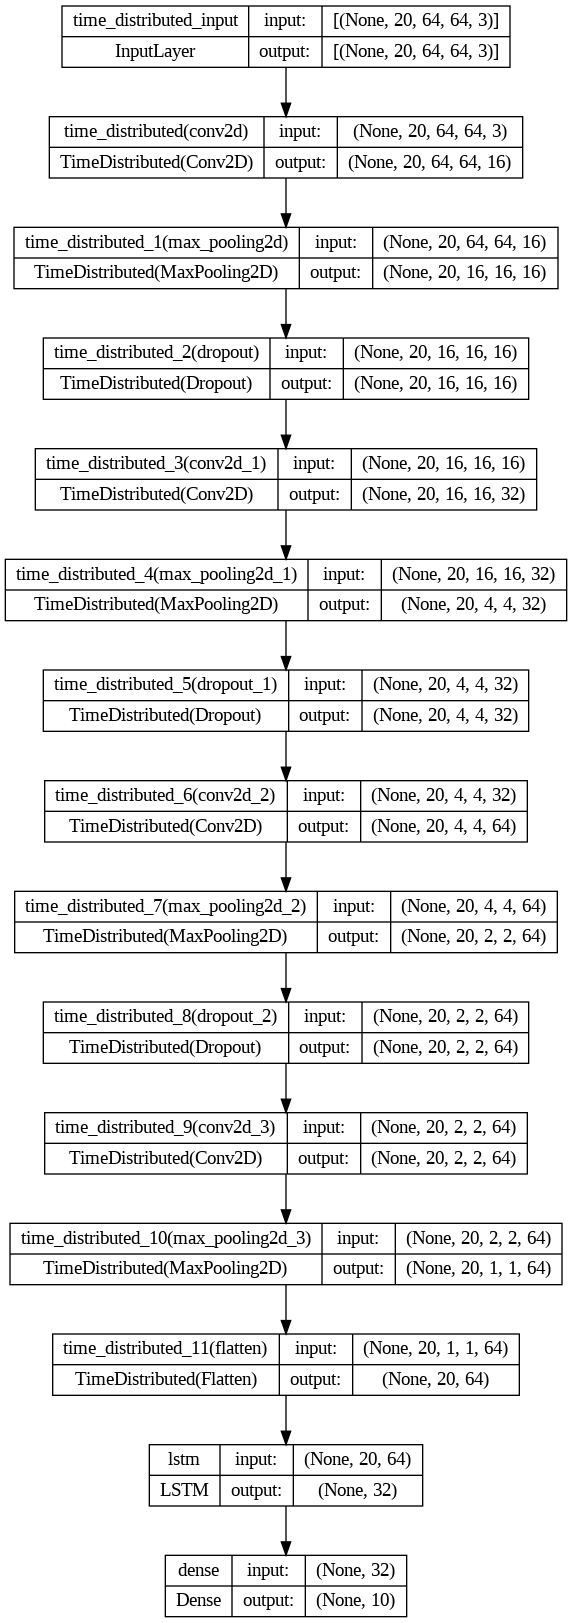

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4, shuffle = True,
                                             validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
199/199 [==============================] - 66s 310ms/step - loss: 2.2853 - accuracy: 0.1583 - val_loss: 2.2060 - val_accuracy: 0.1457
Epoch 2/70
199/199 [==============================] - 49s 245ms/step - loss: 2.1001 - accuracy: 0.2274 - val_loss: 2.1043 - val_accuracy: 0.2261
Epoch 3/70
199/199 [==============================] - 68s 341ms/step - loss: 1.9706 - accuracy: 0.2940 - val_loss: 2.1516 - val_accuracy: 0.2462
Epoch 4/70
199/199 [==============================] - 51s 258ms/step - loss: 1.8916 - accuracy: 0.3266 - val_loss: 1.8645 - val_accuracy: 0.3668
Epoch 5/70
199/199 [==============================] - 48s 242ms/step - loss: 1.7586 - accuracy: 0.3844 - val_loss: 1.6811 - val_accuracy: 0.4070
Epoch 6/70
199/199 [==============================] - 48s 241ms/step - loss: 1.6345 - accuracy: 0.4058 - val_loss: 1.5799 - val_accuracy: 0.4271
Epoch 7/70
199/199 [==============================] - 46s 232ms/step - loss: 1.5002 - accuracy: 0.4673 - val_loss: 1.6915 - val_ac

In [ ]:
# Get the loss and accuracy of Test Data from model_training_history.
train_data_loss = np.average(LRCN_model_training_history.history['loss'])
train_data_accuracy = np.average(LRCN_model_training_history.history['accuracy'])

# Display the Accuracy and Loss of Test Data.
print(f'Average Accuracy of Train Data: {round(train_data_accuracy * 100, 2)} %')
print(f'Average Loss of Train Data: {train_data_loss}')

# Get the loss and accuracy of Validation Data from model_training_history.
val_data_loss = np.average(LRCN_model_training_history.history['val_loss'])
val_data_accuracy = np.average(LRCN_model_training_history.history['val_accuracy'])

# Display the Accuracy and Loss of Validation Data.
print(f'\nAverage Accuracy of Validation Data: {round(val_data_accuracy * 100, 2)} %')
print(f'Average Loss of Validation Data: {val_data_loss}')

Average Accuracy of Train Data: 84.55 %
Average Loss of Train Data: 0.4498292713595385

Average Accuracy of Validation Data: 75.96 %
Average Loss of Validation Data: 0.7376828875505563


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

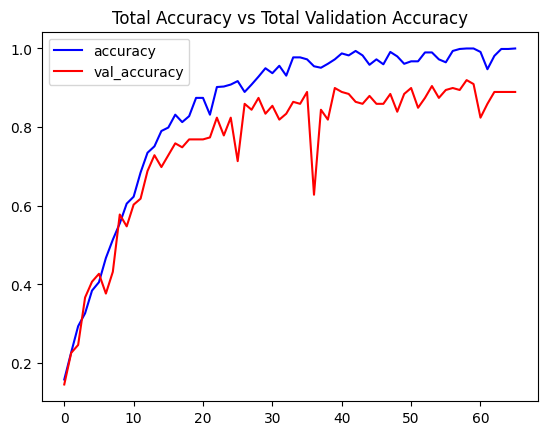

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

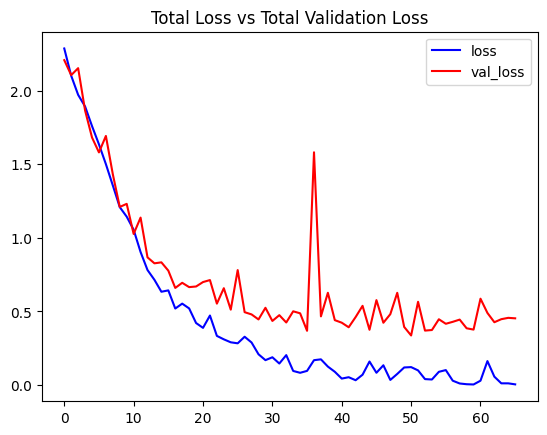

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

# Get the loss and accuracy from model_evaluation_history.
test_data_loss, test_data_accuracy = model_evaluation_history

# Display the Accuracy and Loss of Test Data.
print(f'\nAccuracy of Test Data: {round(test_data_accuracy * 100, 2)} %\nLoss of Test Data: {test_data_loss}')

11/11 [==============================] - 14s 1s/step - loss: 0.6130 - accuracy: 0.8554

Accuracy of Test Data: 85.54 %
Loss of Test Data: 0.613020122051239


In [ ]:
# Define the string date format.
date_time_format = '%Y_%m_%d__%H_%M_%S'

# Get the current Date and Time in a DateTime Object.
current_date_time_dt = dt.datetime.now()

# Convert the DateTime object to string according to the style mentioned in date_time_format string.
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model_Date_Time_{current_date_time_string}_Accuracy_{test_data_accuracy}_Loss_{test_data_loss}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
        extension: The extension of the downloaded youtube video.
    '''

    # Create the output directory if it doesn't exist.
    os.makedirs(output_directory, exist_ok = True)

    # Customizing the download options.
    ydl_opts = {
        'format': '(bestvideo+bestaudio)/best',
        'outtmpl': f'{output_directory}/%(title)s.%(ext)s',
    }

    # Create a video object which contains useful information about the video.
    ydl = youtube_dl.YoutubeDL(ydl_opts)

    # Extract the information about the video and download it.
    info_dict = ydl.extract_info(youtube_video_url, download = True)

    # Retrieve the title of the video.
    video_title = info_dict['title']

    # Retrieve the extension of the video.
    video_extension = info_dict['ext']

    # Return the video title and video extension.
    return video_title, video_extension

In [ ]:
# Specify the directory to store test videos.
test_videos_directory = 'Test Videos'

# Specify the youtube video url to download.
video_url = 'https://youtu.be/8u0qjmHIOcE'

# Download a YouTube Video.
video_title, video_extension = download_youtube_videos(video_url, test_videos_directory)

[youtube] Extracting URL: https://youtu.be/8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading android player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[info] 8u0qjmHIOcE: Downloading 1 format(s): 133+251
[download] Destination: Test Videos/Test Video.f133.mp4
[download] 100% of  744.19KiB in 00:00:00 at 2.95MiB/s   
[download] Destination: Test Videos/Test Video.f251.webm
[download] 100% of   14.02KiB in 00:00:00 at 108.24KiB/s 
[Merger] Merging formats into "Test Videos/Test Video.mkv"
Deleting original file Test Videos/Test Video.f133.mp4 (pass -k to keep)
Deleting original file Test Videos/Test Video.f251.webm (pass -k to keep)


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the frames per second (fps) of the video.
    original_video_fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   original_video_fps, (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Discard the output of this cell.
%%capture

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.{video_extension}'

# Construct the output video path to save the video with predicted actions.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.{video_extension}'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

In [ ]:
# Display the output video.
VideoFileClip(output_video_file_path, audio = False, target_resolution = (300, None)).ipython_display()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
        video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
        SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    Returns:
        predicted_class_name: The predicted class name of the downloaded youtube video.
        predicted_class_probability: The predicted class probability of the downloaded youtube video.
    '''

    # Extracting the video frames.
    frames_list = frames_extraction(video_file_path)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.array([frames_list]))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Get the class name using the retrieved index.
    predicted_class_probability = predicted_labels_probabilities[predicted_label]

    # Return the predicted class name and predicted class probability.
    return predicted_class_name, predicted_class_probability

In [ ]:
# Specify the youtube video url to download.
video_url1 = input("Enter the Youtube Video URL: ")

# Download a YouTube Video.
video_title1, video_extension1 = download_youtube_videos(video_url1, test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path1 = f'{test_videos_directory}/{video_title1}.{video_extension1}'

# Perform Single Prediction on the Test Video.
predicted_class_name, predicted_class_probability = predict_single_action(input_video_file_path1, SEQUENCE_LENGTH)

# Display the predicted action along with the prediction confidence.
print(f'\nAction Predicted: {predicted_class_name}\nConfidence: {round(predicted_class_probability * 100, 2)} %\n')

# Display the input video.
VideoFileClip(input_video_file_path1, audio = False, target_resolution = (300, None)).ipython_display(maxduration = 1000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Test Links
# WalkingWithDog - https://youtube.com/shorts/I4P_YE3HaA4?feature=share
# Taichi - https://youtu.be/fc3w827kwyA
# HorseRace - https://www.youtube.com/shorts/N1NuJulz79M
# Punch - https://youtube.com/shorts/kZf7sRk0TgA?feature=share
# Swing - https://youtube.com/shorts/5lywEV9XjWw?feature=share
# PushUps - https://youtu.be/hIkeJVV-Djk
# MilitaryParade - https://youtube.com/shorts/tRyaa7Qh5ak?feature=share
# GolfSwing - https://youtube.com/shorts/2hG2i0_EKTg?feature=share

In [ ]:
# !rm -rf UCF50

In [ ]:
# def create_convlstm_model():
#     '''
#     This function will construct the required convlstm model.
#     Returns:
#         model: It is the required constructed convlstm model.
#     '''

#     # We will use a Sequential model for model construction.
#     model = Sequential()

#     # Define the Model Architecture.
#     ########################################################################################################################

#     model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     model.add(TimeDistributed(Dropout(0.2)))

#     model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
#                          recurrent_dropout=0.2, return_sequences=True))

#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#     # model.add(TimeDistributed(Dropout(0.2)))

#     model.add(Flatten())

#     model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

#     ########################################################################################################################

#     # Display the models summary.
#     model.summary()

#     # Return the constructed convlstm model.
#     return model

In [ ]:
# # Construct the required convlstm model.
# convlstm_model = create_convlstm_model()

# # Display the success message.
# print("Model Created Successfully!")

In [ ]:
# # Plot the structure of the contructed model.
# plot_model(convlstm_model, to_file = 'ConvLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model.
# convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
# convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
# Evaluate the trained model.
# model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
# model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
# convlstm_model.save(model_file_name)

In [ ]:
# Visualize the training and validation loss metrices.
# plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')